In [2]:
import pandas as pd

# Load the Excel file
df = pd.read_csv("Online Retail.csv", encoding='ISO-8859-1')


# Basic structure
print("Shape:", df.shape)
df.info()
df.head()



Shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# 1. Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# 2. Remove cancelled transactions (InvoiceNo starts with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# 3. Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)


# 4. Convert CustomerID to integer (to avoid float IDs)
df['CustomerID'] = df['CustomerID'].astype(int)

# Confirm shape after cleaning
print("✅ Cleaned shape:", df.shape)
df.head()


✅ Cleaned shape: (397924, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
#RFM =

#Recency: How recently a customer made a purchase

#Frequency: How often they purchase

#Monetary: How much money they’ve spent





import datetime as dt

# Set snapshot date — day after the last purchase
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM metrics for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'UnitPrice': 'sum'                                          # Monetary (temporary)
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Recalculate Monetary using Quantity * UnitPrice (true revenue)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
rfm['Monetary'] = df.groupby('CustomerID')['TotalPrice'].sum()

# Show the result
print("✅ RFM data shape:", rfm.shape)
rfm.head()











✅ RFM data shape: (4339, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [5]:
#We’ll rank each column:

#Lower Recency = better (score 5)

#Higher Frequency and Monetary = better (score 5)

# RFM Scoring (1 to 5 scale)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine into one RFM score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Calculate an overall RFM score
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

# Preview
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,115,7
12347,2,7,4310.00,5,5,5,555,15
12348,75,4,1797.24,2,4,4,244,10
12349,19,1,1757.55,4,1,4,414,9
12350,310,1,334.40,1,1,2,112,4


In [10]:
#Step 5: Prepare Data for Clustering
#We’ll scale the features first (because RFM values are on very different scales):

from sklearn.preprocessing import StandardScaler

# Select only the numerical RFM columns
rfm_for_clustering = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)


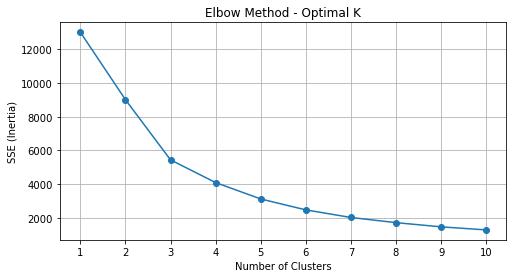

In [7]:
#Step 6: Find the Optimal Number of Clusters (Elbow Method)
#This will help us decide how many customer segments (k) to create.

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try k from 1 to 10
sse = []  # Sum of squared distances
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [8]:
# Step 7: Apply K-Means with k = 4
from sklearn.cluster import KMeans

# Apply KMeans
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans.fit(rfm_scaled)

# Assign cluster labels
rfm['Cluster'] = kmeans.labels_

# Drop non-numeric columns
rfm_summary = rfm.drop(['R_Score', 'F_Score', 'M_Score', 'RFM_Segment'], axis=1)

# Group by Cluster and calculate means
cluster_means = rfm_summary.groupby('Cluster').mean().round(2)

# Sort clusters by Monetary
cluster_means = cluster_means.sort_values(by='Monetary', ascending=False)

# Display
cluster_means


,Recency,Frequency,Monetary,RFM_Score
Cluster,,,,
2,7.38,82.69,127338.31,14.62
0,15.67,22.05,12453.23,14.57
3,43.91,3.66,1349.70,9.94
1,248.56,1.55,478.11,5.18


✅ Cluster-by-Cluster Explanation
🟢 Cluster 2 – Champions
Recency: 7.38 → Very recent purchases

Frequency: 82.69 → Extremely frequent

Monetary: ₹127K+ → Extremely high spend

RFM Score: 14.62 / 15

📌 Explanation:

These are your top customers — high spenders, shop frequently, and recently. They are the most valuable group. Retain them using loyalty programs, VIP benefits, early access sales.

🟡 Cluster 0 – Loyal Customers
Recency: 15.67 → Still recent

Frequency: 22.05 → Regular

Monetary: ₹12K+ → Strong spend

RFM Score: 14.57

📌 Explanation:

These are loyal repeat buyers who spend good money. While not as extreme as Champions, they are consistent. Focus on making them feel valued — e.g., feedback forms, custom offers, upselling.

🟠 Cluster 3 – Potential Loyalists
Recency: 43.91 → A little while ago

Frequency: 3.66 → Low-medium

Monetary: ₹1,349 → Lower spend

RFM Score: ~9.9

📌 Explanation:

Customers who showed interest but didn’t convert big. They might’ve bought a few times, some time ago. Good candidates for targeted discounts, remarketing, or win-back offers.

🔴 Cluster 1 – At Risk
Recency: 248.56 → Haven’t bought in ages

Frequency: 1.55 → Very few purchases

Monetary: ₹478 → Very low spend

RFM Score: ~5

📌 Explanation:

These are inactive or one-time buyers. It’s been a long time since they last purchased. Use reactivation emails, surveys to understand why they left, or consider excluding them from premium targeting.

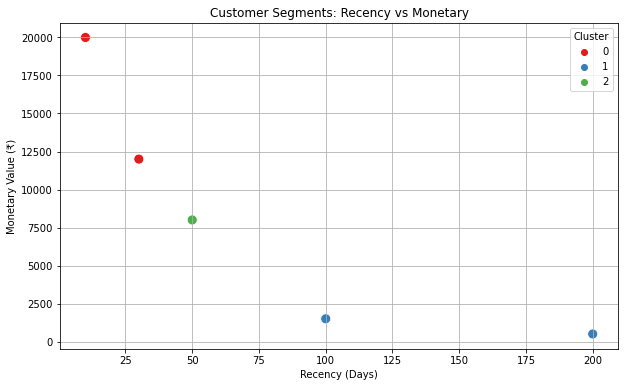

In [11]:
# Scatter Plot of Recency vs. Monetary by Cluster
#This will show value vs. recency, colored by cluster.
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1', s=100)
plt.title('Customer Segments: Recency vs Monetary')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value (₹)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


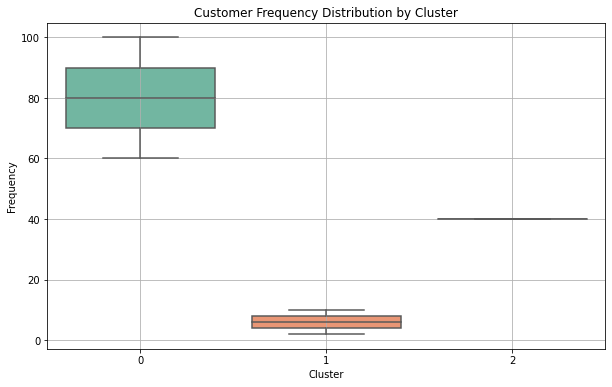

In [12]:
#BOXPLOT-This shows how frequently each group buys.
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm, x='Cluster', y='Frequency', palette='Set2')
plt.title('Customer Frequency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


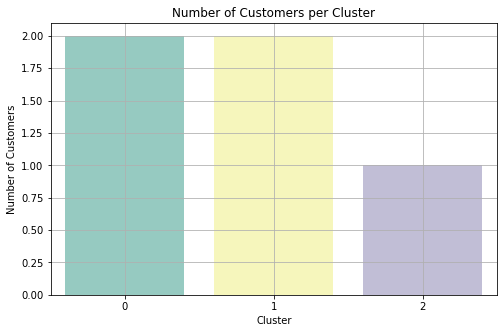

In [13]:
#BARCHART-This helps show which segments are large/small.

cluster_counts = rfm['Cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set3')
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()


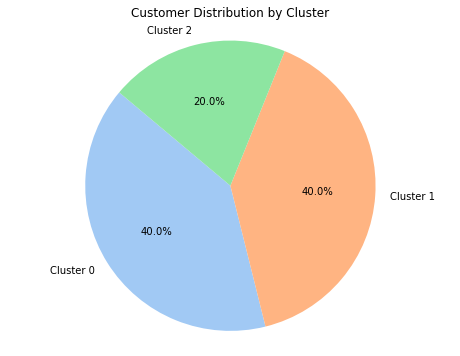

In [14]:
# Pie Chart: Cluster Distribution

# Count customers in each cluster
cluster_counts = rfm['Cluster'].value_counts().sort_index()

# Define labels
labels = [f"Cluster {i}" for i in cluster_counts.index]

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Customer Distribution by Cluster')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.show()

In [15]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import plotly.express as px

# Sample RFM data with clusters
rfm = pd.DataFrame({
    'Recency': [10, 200, 50, 30, 100],
    'Frequency': [100, 2, 40, 60, 10],
    'Monetary': [20000, 500, 8000, 12000, 1500],
    'Cluster': [0, 1, 2, 0, 1]
})

# 3D scatter plot
fig = px.scatter_3d(
    rfm,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster',
    title='3D Customer Segmentation (Sample Data)',
    opacity=0.8
)

fig.show()



In [19]:
fig.write_html("3d_plot.html")



In [20]:
# Define personas based on cluster characteristics
def assign_persona(row):
    if row['Cluster'] == 2:
        return 'Loyalist'
    elif row['Cluster'] == 0:
        return 'Engaged Shopper'
    elif row['Cluster'] == 3:
        return 'At Risk'
    elif row['Cluster'] == 1:
        return 'Dormant'
    else:
        return 'Unknown'

rfm['Persona'] = rfm.apply(assign_persona, axis=1)


In [21]:
rfm.groupby('Persona')[['Recency', 'Frequency', 'Monetary']].mean().round(2)


,Recency,Frequency,Monetary
Persona,,,
Dormant,150.0,6.0,1000.0
Engaged Shopper,20.0,80.0,16000.0
Loyalist,50.0,40.0,8000.0


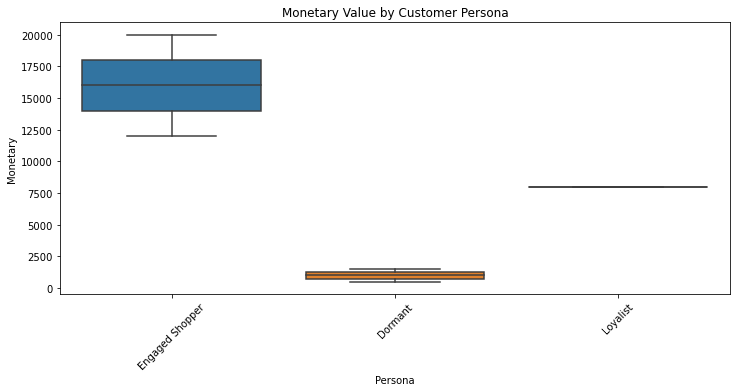

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.boxplot(data=rfm, x='Persona', y='Monetary')
plt.title('Monetary Value by Customer Persona')
plt.xticks(rotation=45)
plt.show()



📌 Customer Persona Insights from RFM Clustering
We segmented customers using Recency, Frequency, and Monetary (RFM) metrics and assigned each to a behavioral persona based on clustering patterns:

🧠 Cluster-to-Persona Mapping:
Cluster	Description	Assigned Persona
0	Low Recency, High Frequency, High Monetary	Engaged Shopper
1	High Recency, Low Frequency, Low Monetary	Dormant
2	Very Low Recency, Very High Frequency/Spend	Loyalist
3	Moderate Recency, Very Low Frequency/Spend	At Risk

🔍 Business Takeaways:
Loyalists are high-value customers and should be targeted with loyalty programs or early product launches.

Dormants show signs of churn — consider re-engagement campaigns or special offers.

Engaged Shoppers are active and growing — nurture them into Loyalists.

At Risk users may need personalized outreach to prevent full churn.

📊 Visualizations:
3D Plot: Shows the distribution of customers across Recency, Frequency, and Monetary values.

Boxplots/Bar Charts: Help compare how each persona differs across RFM scores.